In [1]:
!cd /content/drive/MyDrive

In [2]:
from zipfile import ZipFile


with ZipFile('/content/drive/MyDrive/dogs-vs-cats.zip','r') as zipObj:
  zipObj.extractall()




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Create subdirectories so the data is in this format**


dataset_dogs_vs_cat
  -train
    --dogs
    --cats
  -test
    --dogs
    --cats

In [4]:
from os import makedirs
#Create directories
dataset_home= 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
  # create label subdirectories
  labeldirs= ['dogs/', 'cats/']
  for labldir in labeldirs:
    newdir= dataset_home + subdir+labldir
    makedirs(newdir, exist_ok = True)


**Now Change dataset to fit this format**

In [5]:
from os import listdir
from shutil import copyfile
#Create directories
from random import seed, random
seed(1)
# define ratio of picture use validation
val_ratio= 0.25
#copy training dataset images into subdirectories
src_directory =  'dogs-vs-cats/train'
dataset_home = 'dataset_dogs_vs_cats/'
for file in listdir(src_directory):
  src= src_directory + '/' + file
  dst_dir= 'train/'
  if random()<val_ratio:
    dist_dir= 'test/'
  if file.startswith('cat'):
    dst = dataset_home + dst_dir +'cats/' +file
    copyfile(src, dst)
  elif file.startswith('dog'):
    dst = dataset_home + dst_dir + 'dogs/' +file
    copyfile(src, dst)





# Prepare model for transfer learning

In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
model = VGG16(include_top= False, input_shape=(224, 224 ,3))

#marked loaded layers as not trainable
for layer in model.layers:
  layer.trainable= False
#Add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation= 'relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)
#define new model
model = Model(inputs=model.inputs,outputs= output)
#Compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


# Run the model using generator

In [7]:
#here we cannot do like before that just train dataset it is big dataset 224,224,3 if we
# train all images at once it will start laging si what we will do
#  here we will send images into batches to RAM So what genrators does it load images
# to RAM in batches and then we will do traning
datagen = ImageDataGenerator(featurewise_center=True)
# Specify imagnet mean values for centering
# prepare Iterator
datagen.mean = [123.68, 116.78, 103.939] #Value for rotataio, clipping etc
# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
     class_mode='binary', batch_size=64, target_size=(224,224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
     class_mode='binary', batch_size=64, target_size=(224,224))
# fit model
history = model.fit_generator(train_it, steps_per_epoch = len(train_it), validation_data= test_it,
                              validation_steps= len(test_it), epochs=5, verbose=1)



Found 25000 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


<ipython-input-7-136e5826dbc6>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch = len(train_it), validation_data= test_it,


Epoch 1/5
391/391 [==============================] - 142s 325ms/step - loss: 0.1746 - accuracy: 0.9663
Epoch 2/5
391/391 [==============================] - 119s 305ms/step - loss: 0.0281 - accuracy: 0.9904
Epoch 3/5
391/391 [==============================] - 120s 308ms/step - loss: 0.0079 - accuracy: 0.9978
Epoch 4/5
391/391 [==============================] - 119s 305ms/step - loss: 0.0020 - accuracy: 0.9996
Epoch 5/5
391/391 [==============================] - 121s 309ms/step - loss: 0.0010 - accuracy: 0.9999


#Plot train loss and train accuracy

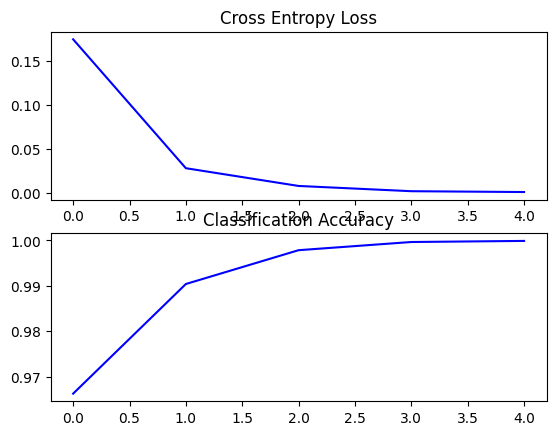

In [19]:
import matplotlib.pyplot as pyplot
import sys
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
#pyplot.plot(history.history['val_loss'],color='orange', label='test')
#plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
#pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename+ '_plot.png')

# Save model for future use

In [20]:
model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict output from the model

In [31]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
# load and prepare the image
# load the image
model= load_model('final_model.h5')
img = load_img('/content/drive/MyDrive/785.jpg', target_size=(224,224))
#convert to array
img = img_to_array(img)
# reshape into a single ample with 3 channels
img = img.reshape(1,224,224,3)
# center pixel data
img = img.astype('float32')
img = img-[123.68, 116.779, 103.939]

In [32]:
result = model.predict(img)
print(result[0])

1/1 [==============================] - 0s 140ms/step
[4.6834754e-23]
